## Dask Arrays

A dask array looks and feels a lot like a numpy array.
However, a dask array doesn't directly hold any data.
Instead, it symbolically represents the computations needed to generate the data.
Nothing is actually computed until the actual numerical values are needed.
This mode of operation is called "lazy"; it allows one to build up complex, large calculations symbolically before turning them over the scheduler for execution.

If we want to create a numpy array of all ones, we do it like this:

In [1]:
import numpy as np
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

This array contains exactly 32 MB of data:

In [2]:
ones_np.nbytes / 1e6

32.0

Now let's create the same array using dask's array interface.

In [3]:
import dask.array as da
ones = da.ones(shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

The dask array representation reveals the concept of "chunks". "Chunks" describes how the array is split into sub-arrays. We did not specify any chunks, so Dask just used one single chunk for the array. This is not much different from a numpy array at this point.

### Specifying Chunks

However, we could have split up the array into many chunks.

![Dask Arrays](http://dask.pydata.org/en/latest/_images/dask-array-black-text.svg)
_source: [Dask Array Documentation](http://dask.pydata.org/en/latest/array-overview.html)_

There are [several ways to specify chunks](http://dask.pydata.org/en/latest/array-creation.html#chunks).
In this lecture, we will use a block shape.

In [4]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Notice that we just see a symbolic represetnation of the array, including its shape, dtype, and chunksize.
No data has been generated yet.
When we call `.compute()` on a dask array, the computation is trigger and the dask array becomes a numpy array.

In [5]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In order to understand what happened when we called `.compute()`, we can visualize the dask _graph_, the symbolic operations that make up the array

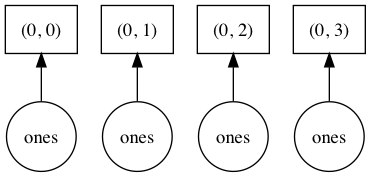

In [6]:
ones.visualize()

Our array has four chunks. To generate it, dask calls `np.ones` four times and then concatenates this together into one array.

Rather than immediately loading a dask array (which puts all the data into RAM), it is more common to want to reduce the data somehow. For example

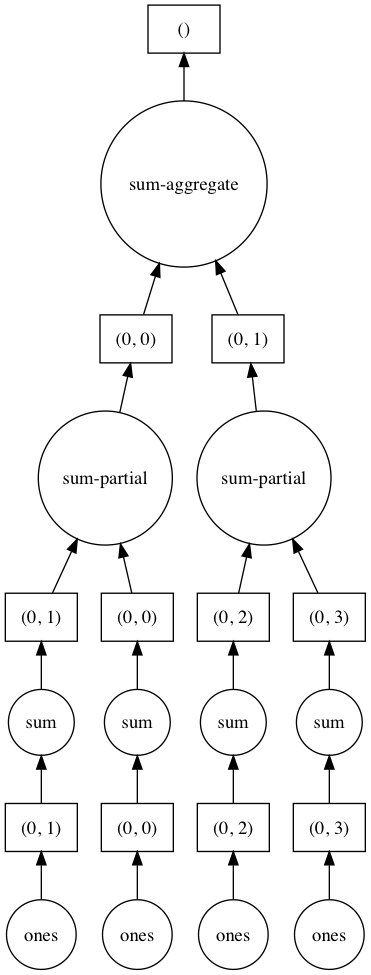

In [7]:
sum_of_ones = ones.sum()
sum_of_ones.visualize()

Here we see dask's strategy for finding the sum. This simple example illustrates the beauty of dask: it automatically designs an algorithm appropriate for custom operations with big data. 

If we make our operation more complex, the graph gets more complex.

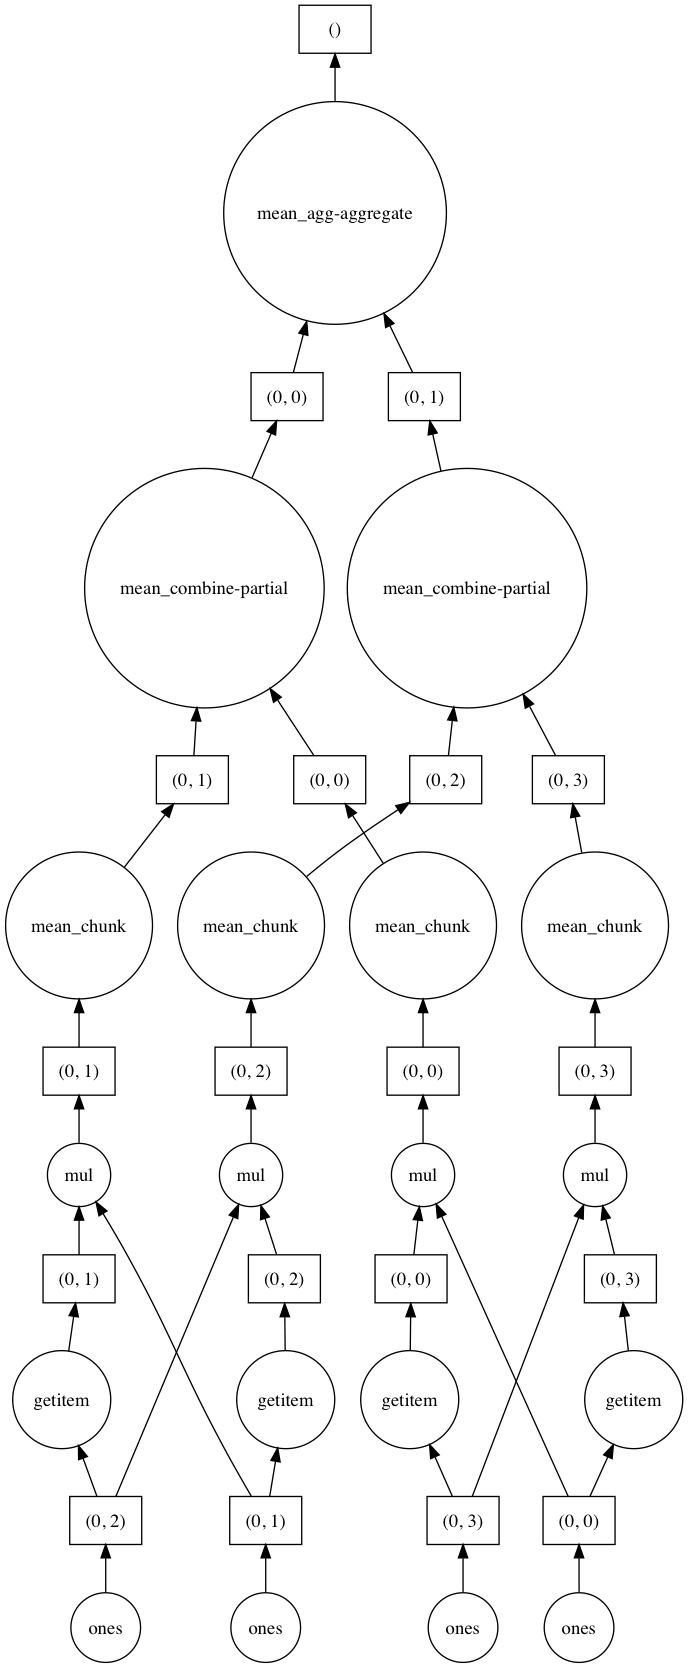

In [8]:
fancy_calculation = (ones * ones[::-1, ::-1]).mean()
fancy_calculation.visualize()

### A Bigger Calculation

The examples above were toy examples; the data (32 MB) is nowhere nearly big enough to warrant the use of dask.

We can make it a lot bigger!

In [9]:
bigshape = (200000, 4000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

,Array,Chunk
Bytes,6.40 GB,8.00 MB
Shape,"(200000, 4000)","(1000, 1000)"
Count,800 Tasks,800 Chunks
Type,float64,numpy.ndarray


In [10]:
big_ones.nbytes / 1e6

6400.0

This dataset is 3.2 GB, rather MB! This is probably close to or greater than the amount of available RAM than you have in your computer. Nevertheless, dask has no problem working on it.

_Do not try to `.visualize()` this array!_

When doing a big calculation, dask also has some tools to help us understand what is happening under the hood

In [11]:
from dask.diagnostics import ProgressBar

big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

with ProgressBar():
    result = big_calc.compute()
result

[########################################] | 100% Completed |  5.2s


1.0

### Reduction 

All the usual numpy methods work on dask arrays.
You can also apply numpy function directly to a dask array, and it will stay lazy.

In [12]:
big_ones_reduce = (np.cos(big_ones)**2).mean(axis=0)
big_ones_reduce

dask.array<mean_agg-aggregate, shape=(4000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

Plotting also triggers computation, since we need the actual values

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

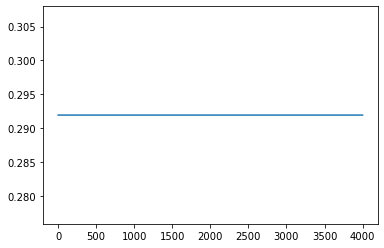

In [14]:
plt.plot(big_ones_reduce)

### Distributed Cluster

For more fancy visualization of what dask is doing, we can use the [distributed scheduler](https://distributed.readthedocs.io/en/latest/).


In [15]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:60261 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [16]:
big_calc.compute()

1.0

In [17]:
random_values = da.random.normal(size=(2e8,), chunks=(1e6,))
hist, bins = da.histogram(random_values, bins=100, range=[-5, 5]) 

In [18]:
hist

dask.array<sum-aggregate, shape=(100,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

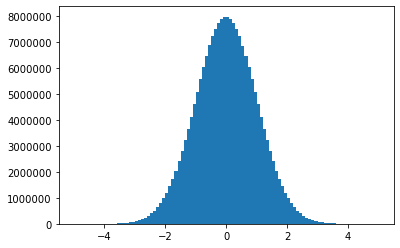

In [19]:
x = 0.5 * (bins[1:] + bins[:-1])
width = np.diff(bins)
hist_c = hist.compute()
plt.bar(x, hist_c, width);

## Dask + XArray

Xarray can automatically wrap its data in dask arrays.
This capability turns xarray into an extremely powerful tool for Big Data earth science

To see this in action, we will download a fairly large dataset to analyze. This file contains 1 year of daily data from the [AVISO](http://www.aviso.oceanobs.com/en/data/products/index.html)
sea-surface height satellite altimetry dataset.

In [20]:
#! wget http://www.ldeo.columbia.edu/~rpa/aviso_madt_2015.tar.gz

In [21]:
! tar -xvzf aviso_madt_2015.tar.gz

x 2015/
x 2015/dt_global_allsat_madt_h_20150409_20150914.nc
x 2015/dt_global_allsat_madt_h_20150406_20150914.nc
x 2015/dt_global_allsat_madt_h_20150704_20160128.nc
x 2015/dt_global_allsat_madt_h_20150223_20150914.nc
x 2015/dt_global_allsat_madt_h_20151220_20160610.nc
x 2015/dt_global_allsat_madt_h_20150912_20160610.nc
x 2015/dt_global_allsat_madt_h_20150607_20160128.nc
x 2015/dt_global_allsat_madt_h_20150320_20150914.nc
x 2015/dt_global_allsat_madt_h_20150608_20160128.nc
x 2015/dt_global_allsat_madt_h_20150512_20160128.nc
x 2015/dt_global_allsat_madt_h_20151029_20160610.nc
x 2015/dt_global_allsat_madt_h_20150618_20160128.nc
x 2015/dt_global_allsat_madt_h_20150502_20160128.nc
x 2015/dt_global_allsat_madt_h_20151026_20160610.nc
x 2015/dt_global_allsat_madt_h_20150330_20150914.nc
x 2015/dt_global_allsat_madt_h_20150617_20160128.nc
x 2015/dt_global_allsat_madt_h_20150826_20160128.nc
x 2015/dt_global_allsat_madt_h_20150416_20150914.nc
x 2015/dt_global_allsat_madt_h_20150829_20160128.nc
x 20

In [22]:
! ls 2015 | wc -l

     365


Let's load the first file as a regular xarray dataset.

In [23]:
import xarray as xr

In [24]:
ds_first = xr.open_dataset('2015/dt_global_allsat_madt_h_20150101_20150914.nc')
ds_first

<xarray.Dataset>
Dimensions:   (lat: 720, lon: 1440, nv: 2, time: 1)
Coordinates:
  * time      (time) datetime64[ns] 2015-01-01
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * nv        (nv) int32 0 1
Data variables:
    lat_bnds  (lat, nv) float32 ...
    lon_bnds  (lon, nv) float32 ...
    crs       int32 ...
    adt       (time, lat, lon) float64 ...
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Absolute Dynamic Topography
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    creator_name:                    SSALTO/DUACS
    creator_url:                     http://www.aviso.altimetry.fr
    date_created:                    2015-10-23T17:07:42Z
    date_issued:                     2015-09-14T00:00:00Z
    date_modified:                   2015-11-13T16:23:24Z
    geospatial_lat_max:              89.875
    geospatial_lat_min:              -89.875
    geospatial_lat_resolution:       0.25
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              359.875
    geospatial_lon_min:              0.125
    geospatial_lon_resolution:       0.25
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2015-10-23T17:07:42Z: created by DUACS D...
    institution:                     CNES, CLS
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://www.aviso.altimetry.fr/fileadmin/...
    platform:                        AltiKa, Cryosat-2, Haiyang-2A, OSTM/Jason-2
    processing_level:                L4
    product_version:                 5.7
    project:                         SSALTO/DUACS :  Data Unification and Alt...
    references:                      http://www.aviso.altimetry.fr
    source:                          Altimetry measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         Delayed-Time Level-4 sea surface height ...
    time_coverage_duration:          P1D
    time_coverage_end:               2015-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2014-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [25]:
ds_first.nbytes / 1e6

8.32034

This one file is about 8 MB. So 365 of them will be nearly 3 GB. If we had downloaded all 25 years of data, it would be 73 GB. This is a good example of "medium data."

### open_mfdataset

An incredibly useful function in xarray is `open_mfdataset`.

In [26]:
help(xr.open_mfdataset)

Help on function open_mfdataset in module xarray.backends.api:

open_mfdataset(paths, chunks=None, concat_dim='_not_supplied', compat='no_conflicts', preprocess=None, engine=None, lock=None, data_vars='all', coords='different', combine='_old_auto', autoclose=None, parallel=False, join='outer', **kwargs)
    Open multiple files as a single dataset.
    
    If combine='by_coords' then the function ``combine_by_coords`` is used to combine
    the datasets into one before returning the result, and if combine='nested' then
    ``combine_nested`` is used. The filepaths must be structured according to which
    combining function is used, the details of which are given in the documentation for
    ``combine_by_coords`` and ``combine_nested``. By default the old (now deprecated)
    ``auto_combine`` will be used, please specify either ``combine='by_coords'`` or
    ``combine='nested'`` in future. Requires dask to be installed. See documentation for
    details on dask [1]. Attributes from the

Using `open_mfdataset` we can easily open all the netcdf files into one `Dataset` object.

In [27]:
# On I got a "Too many open files" OSError.
# It's only 365 files. That shouldn't be too many. 
# However, I discovered my ulimit was extremely low.
# One workaround is to call 
#  $ ulimit -S -n 4000
# from the command line before launching the notebook

ds = xr.open_mfdataset('2015/*.nc')
ds

/Users/rpa/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/Users/rpa/Code/xarray/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


<xarray.Dataset>
Dimensions:   (lat: 720, lon: 1440, nv: 2, time: 365)
Coordinates:
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * nv        (nv) int32 0 1
  * time      (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
Data variables:
    lat_bnds  (time, lat, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds  (time, lon, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    crs       (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    adt       (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Absolute Dynamic Topography
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    creator_name:                    SSALTO/DUACS
    creator_url:                     http://www.aviso.altimetry.fr
    date_created:                    2015-10-23T17:07:42Z
    date_issued:                     2015-09-14T00:00:00Z
    date_modified:                   2015-11-13T16:23:24Z
    geospatial_lat_max:              89.875
    geospatial_lat_min:              -89.875
    geospatial_lat_resolution:       0.25
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              359.875
    geospatial_lon_min:              0.125
    geospatial_lon_resolution:       0.25
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2015-10-23T17:07:42Z: created by DUACS D...
    institution:                     CNES, CLS
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://www.aviso.altimetry.fr/fileadmin/...
    platform:                        AltiKa, Cryosat-2, Haiyang-2A, OSTM/Jason-2
    processing_level:                L4
    product_version:                 5.7
    project:                         SSALTO/DUACS :  Data Unification and Alt...
    references:                      http://www.aviso.altimetry.fr
    source:                          Altimetry measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         Delayed-Time Level-4 sea surface height ...
    time_coverage_duration:          P1D
    time_coverage_end:               2015-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2014-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

Note that the values are not displayed, since that would trigger computation.

In [28]:
ssh = ds.adt
ssh

<xarray.DataArray 'adt' (time: 365, lat: 720, lon: 1440)>
dask.array<concatenate, shape=(365, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
Attributes:
    grid_mapping:   crs
    long_name:      Absolute Dynamic Topography
    standard_name:  sea_surface_height_above_geoid
    units:          m

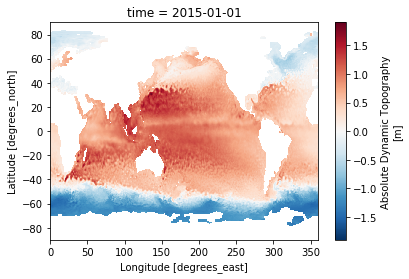

In [29]:
ssh[0].plot()

In [30]:
ssh_2015_mean = ssh.mean(dim='time')
ssh_2015_mean.load()

<xarray.DataArray 'adt' (lat: 720, lon: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875

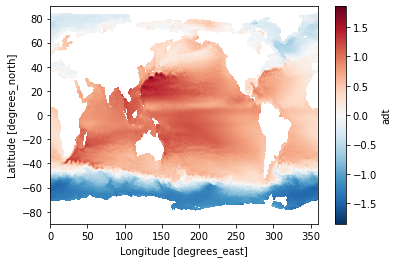

In [31]:
ssh_2015_mean.plot()

In [32]:
ssh_anom = ssh - ssh_2015_mean
ssh_variance_lonmean = (ssh_anom**2).mean(dim=('lon', 'time'))

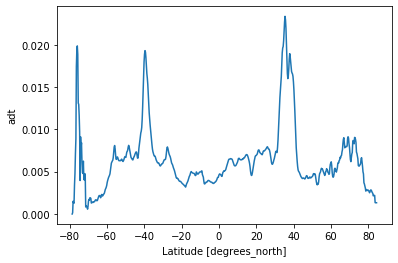

In [33]:
ssh_variance_lonmean.plot()

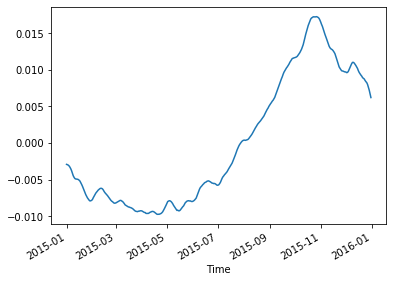

In [39]:
weight = np.cos(np.deg2rad(ds.lat))
weight /= weight.mean()
(ssh_anom * weight).mean(dim=('lon', 'lat')).plot()

## Cloud Storage

Since we are in the cloud, we can also skip the whole "download" step and just work with data stored directly in cloud storage.

There are a lot of different pieces that make this work:
- [Pangeo Cloud Data Catalog](https://pangeo-data.github.io/pangeo-datastore/)
- [Intake](https://intake.readthedocs.io/)
- [Zarr](https://zarr.readthedocs.io/)

We don't have time to go over them all.

In [40]:
import intake
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds = cat["sea_surface_height"].to_dask()
ds

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 8901)
Coordinates:
    crs        int32 ...
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(5, 720, 2), meta=np.ndarray>
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
    lon_bnds   (longitude, nv) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                    CMEMS - Sea Level Thematic Assembly Center
    creator_url:                     http://marine.copernicus.eu
    date_created:                    2014-02-26T16:09:13Z
    date_issued:                     2014-01-06T00:00:00Z
    date_modified:                   2015-11-10T19:42:51Z
    geospatial_lat_max:              89.875
    geospatial_lat_min:              -89.875
    geospatial_lat_resolution:       0.25
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              359.875
    geospatial_lon_min:              0.125
    geospatial_lon_resolution:       0.25
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2014-02-26T16:09:13Z: created by DUACS D...
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://marine.copernicus.eu/web/27-servi...
    platform:                        ERS-1, Topex/Poseidon
    processing_level:                L4
    product_version:                 5.0
    project:                         COPERNICUS MARINE ENVIRONMENT MONITORING...
    references:                      http://marine.copernicus.eu
    source:                          Altimetry measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [41]:
ds.sla.data

,Array,Chunk
Bytes,73.83 GB,41.47 MB
Shape,"(8901, 720, 1440)","(5, 720, 1440)"
Count,1782 Tasks,1781 Chunks
Type,float64,numpy.ndarray
